# Diamond Prices: Model Tuning and Improving Performance

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.options.mode.chained_assignment = None
%matplotlib inline

#### Loading the dataset

In [2]:
DATA_DIR = '../data'
FILE_NAME = 'diamonds.csv'
data_path = os.path.join(DATA_DIR, FILE_NAME)
diamonds = pd.read_csv(data_path)

#### Preparing the dataset

In [3]:
## Preparation done from Chapter 2
diamonds = diamonds.loc[(diamonds['x']>0) | (diamonds['y']>0)]
diamonds.loc[11182, 'x'] = diamonds['x'].median()
diamonds.loc[11182, 'z'] = diamonds['z'].median()
diamonds = diamonds.loc[~((diamonds['y'] > 30) | (diamonds['z'] > 30))]
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['cut'], prefix='cut', drop_first=True)], axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], prefix='color', drop_first=True)], axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], prefix='clarity', drop_first=True)], axis=1)

## Dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=1, random_state=123)
diamonds['dim_index'] = pca.fit_transform(diamonds[['x','y','z']])
diamonds.drop(['x','y','z'], axis=1, inplace=True)

In [4]:
diamonds.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price',
       'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF',
       'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2',
       'clarity_VVS1', 'clarity_VVS2', 'dim_index'],
      dtype='object')

#### Train-test split

In [5]:
X = diamonds.drop(['cut','color','clarity','price'], axis=1)
y = diamonds['price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

#### Standarization: centering and scaling 

In [6]:
numerical_features = ['carat', 'depth', 'table', 'dim_index']
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train.loc[:, numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

## Optimizing a single hyper-parameter

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=13)

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

candidates = np.arange(4,16)
mae_metrics = []
for k in candidates:
    model = KNeighborsRegressor(n_neighbors=k, weights='distance', metric='minkowski', leaf_size=50, n_jobs=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    metric = mean_absolute_error(y_true=y_val, y_pred=y_pred)
    mae_metrics.append(metric)

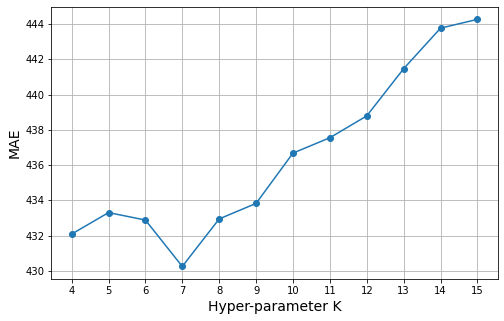

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(candidates, mae_metrics, "o-")
ax.set_xlabel('Hyper-parameter K', fontsize=14)
ax.set_ylabel('MAE', fontsize=14)
ax.set_xticks(candidates)
ax.grid();

#### Recalculating train-set split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train.loc[:, numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

#### Optimizing with cross-validation

In [11]:
from sklearn.model_selection import cross_val_score
candidates = np.arange(4,16)
mean_mae = []
std_mae = []
for k in candidates:
    model = KNeighborsRegressor(n_neighbors=k, weights='distance', metric='minkowski', leaf_size=50, n_jobs=4)
    cv_results = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
    mean_score, std_score = -1*cv_results.mean(), cv_results.std()
    mean_mae.append(mean_score)
    std_mae.append(std_score)

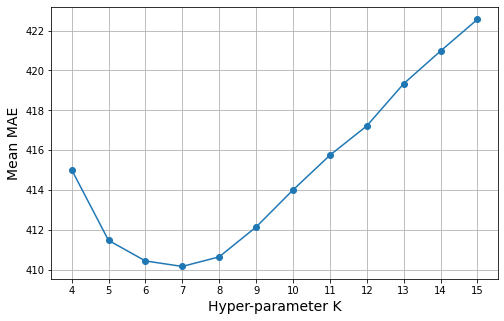

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(candidates, mean_mae, "o-")
ax.set_xlabel('Hyper-parameter K', fontsize=14)
ax.set_ylabel('Mean MAE', fontsize=14)
ax.set_xticks(candidates)
ax.grid();

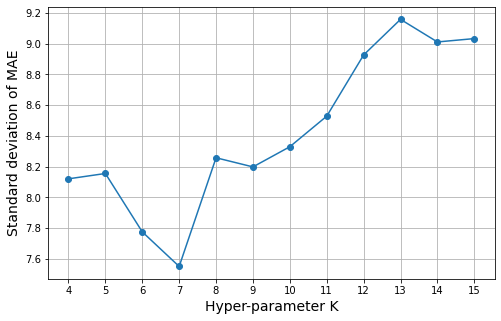

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(candidates, std_mae, "o-")
ax.set_xlabel('Hyper-parameter K', fontsize=14)
ax.set_ylabel('Standard deviation of MAE', fontsize=14)
ax.set_xticks(candidates)
ax.grid();

# Improving Performance

## Improving our diamond price predictions

### Fitting a neural network

In [14]:
from keras.models import Sequential
from keras.layers import Dense

n_input = X_train.shape[1]
n_hidden1 = 32
n_hidden2 = 16
n_hidden3 = 8

nn_reg = Sequential()
nn_reg.add(Dense(units=n_hidden1, activation='relu', input_shape=(n_input,)))
nn_reg.add(Dense(units=n_hidden2, activation='relu'))
nn_reg.add(Dense(units=n_hidden3, activation='relu'))
# output layer
nn_reg.add(Dense(units=1, activation=None))

Using TensorFlow backend.


In [15]:
batch_size = 32
n_epochs = 40
nn_reg.compile(loss='mean_absolute_error', optimizer='adam')
nn_reg.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.05)

Train on 46110 samples, validate on 2427 samples
Epoch 1/40
46110/46110 [==============================] - 3s 60us/step - loss: 1923.8649 - val_loss: 740.0315
Epoch 2/40
46110/46110 [==============================] - 2s 50us/step - loss: 607.4982 - val_loss: 561.1316
Epoch 3/40
46110/46110 [==============================] - 2s 50us/step - loss: 498.9242 - val_loss: 473.0878
Epoch 4/40
46110/46110 [==============================] - 2s 51us/step - loss: 434.3081 - val_loss: 428.8252
Epoch 5/40
46110/46110 [==============================] - 2s 50us/step - loss: 400.5281 - val_loss: 405.8629
Epoch 6/40
46110/46110 [==============================] - 2s 52us/step - loss: 383.6656 - val_loss: 394.4680
Epoch 7/40
46110/46110 [==============================] - 2s 52us/step - loss: 375.1220 - val_loss: 389.4772
Epoch 8/40
46110/46110 [==============================] - 2s 54us/step - loss: 369.4259 - val_loss: 383.3422
Epoch 9/40
46110/46110 [==============================] - 3s 58us/step - loss:

In [16]:
y_pred = nn_reg.predict(X_test).flatten()
mae_neural_net = mean_absolute_error(y_test, y_pred)
print("MAE Neural Network: {:0.2f}".format(mae_neural_net))

MAE Neural Network: 348.94


### Transforming the target

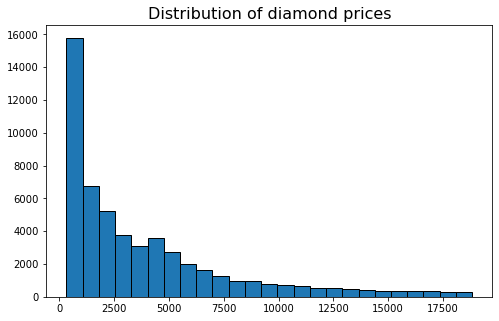

In [17]:
diamonds['price'].hist(bins=25, ec='k', figsize=(8,5))
plt.title("Distribution of diamond prices", fontsize=16)
plt.grid(False);

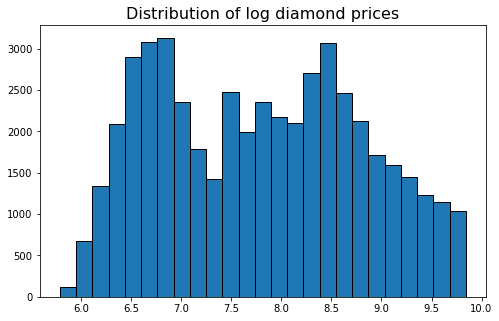

In [18]:
y_train = np.log(y_train)
pd.Series(y_train).hist(bins=25, ec='k', figsize=(8,5))
plt.title("Distribution of log diamond prices", fontsize=16)
plt.grid(False);

In [19]:
nn_reg = Sequential()
nn_reg.add(Dense(units=n_hidden1, activation='relu', input_shape=(n_input,)))
nn_reg.add(Dense(units=n_hidden2, activation='relu'))
nn_reg.add(Dense(units=n_hidden3, activation='relu'))
# output layer
nn_reg.add(Dense(units=1, activation=None))

In [20]:
batch_size = 32
n_epochs = 40
nn_reg.compile(loss='mean_absolute_error', optimizer='adam')
nn_reg.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.05)

Train on 46110 samples, validate on 2427 samples
Epoch 1/40
46110/46110 [==============================] - 3s 58us/step - loss: 0.6144 - val_loss: 0.1476
Epoch 2/40
46110/46110 [==============================] - 3s 54us/step - loss: 0.1366 - val_loss: 0.1270
Epoch 3/40
46110/46110 [==============================] - 2s 50us/step - loss: 0.1206 - val_loss: 0.1180
Epoch 4/40
46110/46110 [==============================] - 2s 50us/step - loss: 0.1107 - val_loss: 0.1079
Epoch 5/40
46110/46110 [==============================] - 2s 47us/step - loss: 0.1047 - val_loss: 0.1031
Epoch 6/40
46110/46110 [==============================] - 2s 48us/step - loss: 0.1020 - val_loss: 0.0963
Epoch 7/40
46110/46110 [==============================] - 2s 45us/step - loss: 0.0983 - val_loss: 0.1228
Epoch 8/40
46110/46110 [==============================] - 2s 44us/step - loss: 0.0964 - val_loss: 0.1144
Epoch 9/40
46110/46110 [==============================] - 2s 46us/step - loss: 0.0949 - val_loss: 0.0935
Epoch 

In [21]:
y_pred = nn_reg.predict(X_test).flatten()
y_pred = np.exp(y_pred)
mae_neural_net2 = mean_absolute_error(y_test, y_pred)
print("MAE Neural Network (modified target): {:0.2f}".format(mae_neural_net2))

MAE Neural Network (modified target): 351.57


In [22]:
100*(mae_neural_net - mae_neural_net2)/mae_neural_net2

-0.7498004603046903

#### Analyzing the results

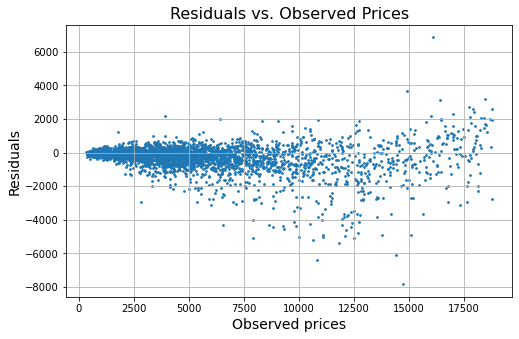

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
residuals = y_test - y_pred
ax.scatter(y_test, residuals, s=3)
ax.set_title('Residuals vs. Observed Prices', fontsize=16)
ax.set_xlabel('Observed prices', fontsize=14)
ax.set_ylabel('Residuals', fontsize=14)
ax.grid();

In [24]:
mask_7500 = y_test <=7500
mae_neural_less_7500 = mean_absolute_error(y_test[mask_7500], y_pred[mask_7500])
print("MAE considering price <= 7500: {:0.2f}".format(mae_neural_less_7500))

MAE considering price <= 7500: 221.76


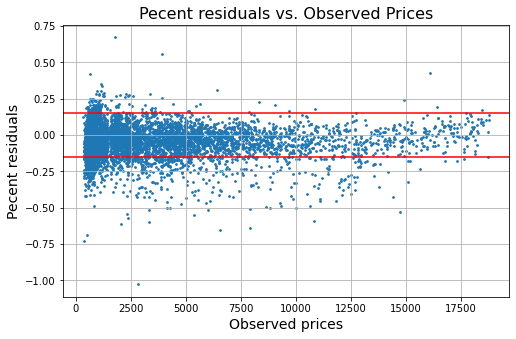

In [25]:
fig, ax = plt.subplots(figsize=(8,5))
percent_residuals = (y_test - y_pred)/y_test
ax.scatter(y_test, percent_residuals, s=3)
ax.set_title('Pecent residuals vs. Observed Prices', fontsize=16)
ax.set_xlabel('Observed prices', fontsize=14)
ax.set_ylabel('Pecent residuals', fontsize=14)
ax.axhline(y=0.15, color='r'); ax.axhline(y=-0.15, color='r'); 
ax.grid();